2025/05/29 22:13:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost logged: acc=0.9983, f1=0.9983


2025/05/29 22:14:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest logged: acc=0.9983, f1=0.9983


2025/05/29 22:14:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM logged: acc=0.9983, f1=0.9983
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Keras_FFNN logged: acc=0.9983, f1=0.9983


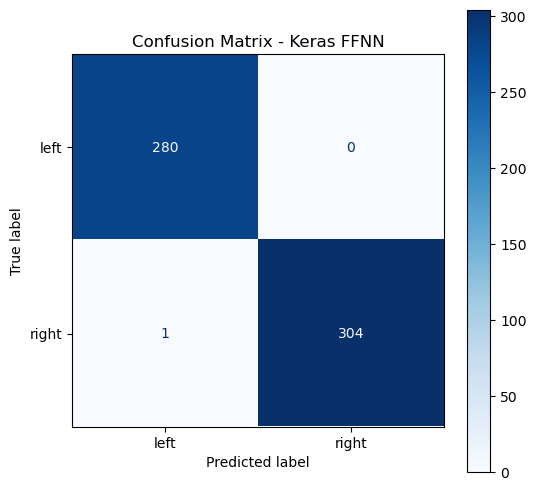

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import mlflow.tensorflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# Load dataset
df = pd.read_csv("hand_landmarks_data.csv")

# Map labels
def map_label(label):
    if label == "peace":
        return "right"
    elif label == "stop":
        return "left"
    elif "right" in label:
        return "right"
    elif "left" in label:
        return "left"
    else:
        return None

df['label'] = df['label'].apply(map_label)
df = df.dropna(subset=['label'])

# Center by wrist (x1, y1, z1)
wrist_x, wrist_y, wrist_z = df['x1'], df['y1'], df['z1']
for i in range(1, 22):
    df[f'x{i}'] -= wrist_x
    df[f'y{i}'] -= wrist_y
    df[f'z{i}'] -= wrist_z

# Normalize by max absolute value
max_value = df.iloc[:, :-1].abs().max(axis=1)
for i in range(1, 22):
    df[f'x{i}'] /= max_value
    df[f'y{i}'] /= max_value
    df[f'z{i}'] /= max_value

# Prepare data
X = df.drop(columns=['label'])
y = df['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=random_state)

# Set MLflow experiment
mlflow.set_experiment("hand_gesture_recognition")

# Models
models = [
    {
        "name": "XGBoost",
        "estimator": XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=200, random_state=random_state)
    },
    {
        "name": "RandomForest",
        "estimator": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=random_state)
    },
    {
        "name": "SVM",
        "estimator": SVC(kernel='rbf', probability=True, C=1.0, random_state=random_state)
    }
]

# Train and log sklearn models
for model_info in models:
    model_name = model_info["name"]
    model = model_info["estimator"]
    
    with mlflow.start_run(run_name=model_name):
        mlflow.set_tag("user", "rania")

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        acc = accuracy_score(y_test, preds)
        precision = precision_score(y_test, preds, average="macro")
        recall = recall_score(y_test, preds, average="macro")
        f1 = f1_score(y_test, preds, average="macro")

        mlflow.log_param("model", model_name)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.sklearn.log_model(model, artifact_path=f"{model_name}_model")

        print(f"{model_name} logged: acc={acc:.4f}, f1={f1:.4f}")

# Keras FFNN
X_train_keras = X_train.astype("float32")
X_test_keras = X_test.astype("float32")
y_train_keras = tf.keras.utils.to_categorical(y_train)
y_test_keras = tf.keras.utils.to_categorical(y_test)
num_classes = y_train_keras.shape[1]

with mlflow.start_run(run_name="Keras_FFNN"):
    mlflow.set_tag("user", "rania")

    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_keras.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train_keras, y_train_keras, validation_split=0.2, epochs=30, batch_size=32, verbose=0)

    y_pred_probs = model.predict(X_test_keras)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_keras, axis=1)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")

    mlflow.log_param("model", "Keras_FFNN")
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    model.save("keras_ffnn_model.keras")
    mlflow.log_artifact("keras_ffnn_model.keras")
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title("Confusion Matrix - Keras FFNN")
    plt.savefig("confusion_matrix_keras.png")
    mlflow.log_artifact("confusion_matrix_keras.png")

    print(f"Keras_FFNN logged: acc={acc:.4f}, f1={f1:.4f}")


In [8]:
import joblib
joblib.dump(model, f"{model_name}_model.pkl")  
mlflow.log_artifact(f"{model_name}_model.pkl")  